##  Capstone Project - The Battle of Neighborhoods（Week 2）-Finding the best Italian restaurant for people who travel to Toronto
***

### Introduction

With the development of economy and society, more and more people like to travel on holidays. Toronto, Canada is an international city which located in the east of Canada, near the border between the United States and Canada. Toronto has very magnificent natural and cultural landscapes. Lots of Americans like to go to Toronto on holidays, but there are also many inconvenient to travel in a strange city. Especially how to find your favorite foods in a strange city? In this project, I will answer that question. This project will help **those who like Italian cuisine to find their favorite restaurants in Toronto**.

### Bussiness Problem

Toronto is an international city with a population of over 3 million. Therefore, it is very difficult to find a favorite restaurant.In this project, I will use the data science knowledge I have learned to answer the following questions:
1. How many Italian restaurants in Toronto?
2. Where could we find these Italian restaurants?
3. Which neighborhood would I recommend to find the best Italian restaurant and why I recommend it?

### Data

 I will use the following data to finish this project:
 
Toronto City data that contains list Post Code, Boroughs and Neighborhoods.
Data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Toronto City data that contains Post Code, latitude and longitude.
Data source: http://cocl.us/Geospatial_data

Italy restaurants in each neighborhood of Toronto,CA.
Data source: **Foursquare API**


### Data analysis

Firstly， let's import some necessary libraries.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

#from bs4 import BeautifulSoup
import os 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

! pip3 install simplejson
import simplejson as json

import seaborn as sns
print('Folium installed')
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.


Next， Define **foursquare credentials** and **version**

In [2]:
CLIENT_ID = 'ICYATA5JGPYIWW5X0NPQKLI5KNR4VMWT5MG5EXIZHP3LDGRJ' # your Foursquare ID
CLIENT_SECRET = 'OLPW0VM13EMCO5UMS4SALKHAZWD2SQOMPIY5UOE0BVTIU4S0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ICYATA5JGPYIWW5X0NPQKLI5KNR4VMWT5MG5EXIZHP3LDGRJ
CLIENT_SECRET:OLPW0VM13EMCO5UMS4SALKHAZWD2SQOMPIY5UOE0BVTIU4S0


Define some necessary **functions** that will be used later.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Then I will analyze some relevant information of Toronto on wikipedia，making a table contain **Postal Code, Borough** and **Neighborhood** of Toronto.

In [4]:
# getting data from internet
source='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_Canada=pd.read_html(source)
# Call the position where the table is stored
neighborhood=df_Canada[0]
# Eliminate the first row
neighborhood=neighborhood.drop([0])
# Eliminate "Not assigned", categorical values from "Borough" Column
neighborhood=neighborhood[neighborhood.Borough !='Not assigned']
# Making DataFrame
neighborhood=pd.DataFrame(neighborhood)
# Merging rows with same Postcode
neighborhood.set_index(['Postal Code','Borough'],inplace=True)
merge_result = neighborhood.groupby(level=['Postal Code','Borough'], sort=False).agg( ','.join)
# Setting the index
serial_wise=merge_result.reset_index()
serial_wise.loc[4, 'Neighborhood']='Queen\'s Park'
serial_wise.to_excel('Canada_table.xls')
df=pd.DataFrame(serial_wise)
df.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
df.shape

(103, 3)

In [ ]:
There are total 103 boroughs in Toronto

In [ ]:
import a new table which contains latitude and longitude and corresponding postal code.

In [6]:
df_geo_coor = pd.read_csv("http://cocl.us/Geospatial_data")
df_geo_coor.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


Merge the above two tables to create a new table containing Borough Neighborhood and the corresponding **latitude** and **longitude**

In [64]:
df_toronto_1 = pd.merge(df, df_geo_coor, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
df_toronto_1.drop(["Postal Code"],axis=1)
df_toronto=df_toronto_1.drop(["Postal Code"],axis=1)
df_toronto.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,North York,Don Mills,43.745906,-79.352188
8,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


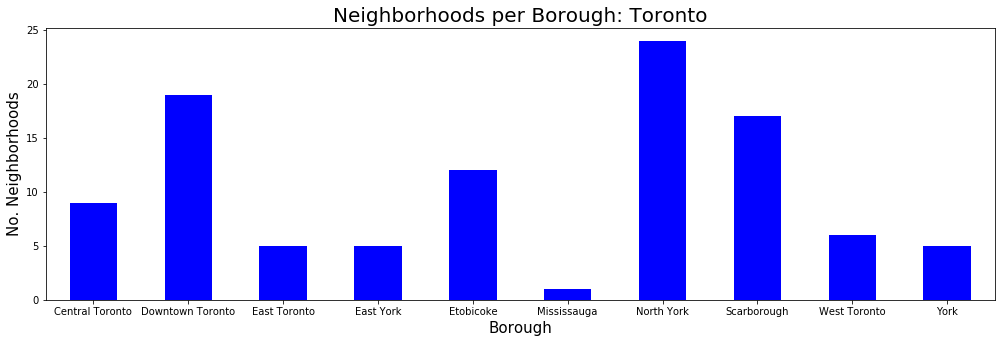

In [53]:
clr = "blue"
df_toronto.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(17,5), color=clr)
plt.title('Neighborhoods per Borough: Toronto', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

The **Downtown Toronto** and **North York** are two Boroughs have the highest number of neighborhoods

Next let's calculate how many italian resturants for each Neighborhood

In [9]:
# prepare neighborhood list that contains Italy resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Italy_rest_Toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_toronto.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(df_toronto),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(Italian_resturants)))
    for resturant_detail in Italian_resturants.values.tolist():
        id, name , category=resturant_detail
        Italy_rest_Toronto = Italy_rest_Toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Italian Resturants in Parkwoods, North York:0
( 2 / 103 ) Italian Resturants in Victoria Village, North York:0
( 3 / 103 ) Italian Resturants in Regent Park, Harbourfront, Downtown Toronto:0
( 4 / 103 ) Italian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Italian Resturants in Queen's Park, Downtown Toronto:1
( 6 / 103 ) Italian Resturants in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Italian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Italian Resturants in Don Mills, North York:0
( 9 / 103 ) Italian Resturants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Italian Resturants in Garden District, Ryerson, Downtown Toronto:3
( 11 / 103 ) Italian Resturants in Glencairn, North York:0
( 12 / 103 ) Italian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Italian Resturants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
( 14 / 103 ) I

In [10]:
Italy_rest_Toronto.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,Queen's Park,4a8355bff964a520d3fa1fe3,Mercatto
1,Downtown Toronto,"Garden District, Ryerson",4d306dd82748b60c62b6dba0,Trattoria Mercatto
2,Downtown Toronto,"Garden District, Ryerson",52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar
3,Downtown Toronto,"Garden District, Ryerson",4afcc52df964a520b82522e3,Donatello Restaurant
4,North York,Don Mills,4bdaff7463c5c9b67bcb2568,Sorento Restaurant


In [11]:
Italy_rest_Toronto.shape

(38, 4)

In [ ]:
There are 38 Italian Resturants in Toronto.

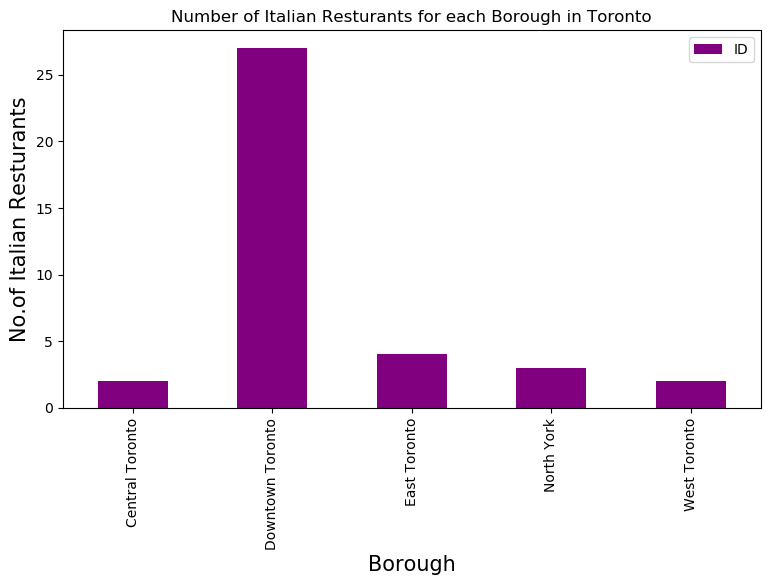

In [70]:
plt.figure(figsize=(9,5), dpi = 100,)
# title
plt.title('Number of Italian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
Italy_rest_Toronto.groupby('Borough')['ID'].count().plot(kind='bar', color= "Purple" )
#legend
plt.legend()
#displays the plot
plt.show()

Downtown Toronto has the largest number of Italian resturants

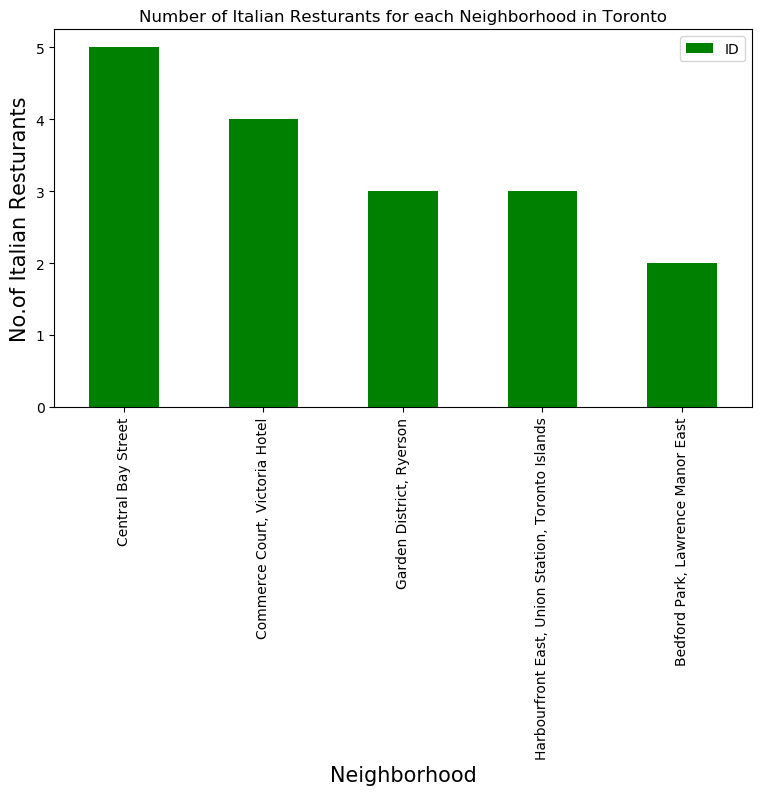

In [61]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
Italy_rest_Toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind="bar", color = "green")
#legend
plt.legend()
#displays the plot
plt.show()

Central Bay Street in Downtown Toronto has the largest number of italian resturants with a total count of **5**.

Next, I will get the **ranking,Likes** and **Tips** of each resturant for further analysis.

In [14]:
Italy_rest_Toronto[Italy_rest_Toronto['Neighborhood']=='Central Bay Street']

,Borough,Neighborhood,ID,Name
6,Downtown Toronto,Central Bay Street,4a8355bff964a520d3fa1fe3,Mercatto
7,Downtown Toronto,Central Bay Street,4afcc52df964a520b82522e3,Donatello Restaurant
8,Downtown Toronto,Central Bay Street,52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar
9,Downtown Toronto,Central Bay Street,54fb2f8d498e724a96c14f91,Tosto
10,Downtown Toronto,Central Bay Street,529d18c911d255c5406ddd88,Pizzeria Via Mercanti


In [15]:
# prepare neighborhood list that contains Italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Italy_rest_stats_Toronto=pd.DataFrame(columns=column_names)
count=1


for row in Italy_rest_Toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Italy_rest_Toronto),')','processed')
    Italy_rest_stats_Toronto = Italy_rest_stats_Toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5edd064d47b43d0023f3695e'}, 'response': {'venue': {'id': '4a8355bff964a520d3fa1fe3', 'name': 'Mercatto', 'contact': {'phone': '4165955625', 'formattedPhone': '(416) 595-5625'}, 'location': {'address': '101 College St', 'lat': 43.660390911898546, 'lng': -79.38766421192705, 'labeledLatLngs': [{'label': 'display', 'lat': 43.660390911898546, 'lng': -79.38766421192705}], 'postalCode': 'M5G', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['101 College St', 'Toronto ON M5G', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/mercatto/4a8355bff964a520d3fa1fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizz

In [66]:
Italy_rest_stats_Toronto.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Queen's Park,4a8355bff964a520d3fa1fe3,Mercatto,56.0,7.8,26.0
1,Downtown Toronto,"Garden District, Ryerson",4d306dd82748b60c62b6dba0,Trattoria Mercatto,105.0,7.4,82.0
2,Downtown Toronto,"Garden District, Ryerson",52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,171.0,7.5,70.0
3,Downtown Toronto,"Garden District, Ryerson",4afcc52df964a520b82522e3,Donatello Restaurant,20.0,7.3,19.0
4,North York,Don Mills,4bdaff7463c5c9b67bcb2568,Sorento Restaurant,9.0,8.2,8.0
5,Downtown Toronto,St. James Town,4b49183ff964a520a46526e3,Terroni,278.0,8.1,95.0
6,Downtown Toronto,Central Bay Street,4a8355bff964a520d3fa1fe3,Mercatto,56.0,7.8,26.0
7,Downtown Toronto,Central Bay Street,4afcc52df964a520b82522e3,Donatello Restaurant,20.0,7.3,19.0
8,Downtown Toronto,Central Bay Street,52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,171.0,7.5,70.0
9,Downtown Toronto,Central Bay Street,54fb2f8d498e724a96c14f91,Tosto,20.0,6.5,17.0


In [17]:
Italy_rest_stats_Toronto.shape

(38, 7)

We have obtained the required information, and now store it in a csv file

In [18]:
Italy_rest_stats_Toronto.to_csv('Italy_rest_stats_Toronto.csv', index=False)

In [19]:
Italy_rest_stats_Toronto_csv=pd.read_csv('Italy_rest_stats_Toronto.csv')

In [20]:
Italy_rest_stats_Toronto_csv.shape

(38, 7)

In [68]:
Italy_rest_stats_Toronto_csv.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Queen's Park,4a8355bff964a520d3fa1fe3,Mercatto,56,7.8,26
1,Downtown Toronto,"Garden District, Ryerson",4d306dd82748b60c62b6dba0,Trattoria Mercatto,105,7.4,82
2,Downtown Toronto,"Garden District, Ryerson",52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,171,7.5,70
3,Downtown Toronto,"Garden District, Ryerson",4afcc52df964a520b82522e3,Donatello Restaurant,20,7.3,19
4,North York,Don Mills,4bdaff7463c5c9b67bcb2568,Sorento Restaurant,9,8.2,8
5,Downtown Toronto,St. James Town,4b49183ff964a520a46526e3,Terroni,278,8.1,95
6,Downtown Toronto,Central Bay Street,4a8355bff964a520d3fa1fe3,Mercatto,56,7.8,26
7,Downtown Toronto,Central Bay Street,4afcc52df964a520b82522e3,Donatello Restaurant,20,7.3,19
8,Downtown Toronto,Central Bay Street,52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,171,7.5,70
9,Downtown Toronto,Central Bay Street,54fb2f8d498e724a96c14f91,Tosto,20,6.5,17


In [22]:
Italy_rest_stats_Toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       38 non-null     object 
 1   Neighborhood  38 non-null     object 
 2   ID            38 non-null     object 
 3   Name          38 non-null     object 
 4   Likes         38 non-null     object 
 5   Rating        38 non-null     float64
 6   Tips          38 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.2+ KB


 Now I will  convert the value of Likes and Tips from **string**  into **float** for further analysis

In [23]:
Italy_rest_stats_Toronto['Likes']=Italy_rest_stats_Toronto['Likes'].astype('float64')

In [24]:
Italy_rest_stats_Toronto['Tips']=Italy_rest_stats_Toronto['Tips'].astype('float64')

In [25]:
Italy_rest_stats_Toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       38 non-null     object 
 1   Neighborhood  38 non-null     object 
 2   ID            38 non-null     object 
 3   Name          38 non-null     object 
 4   Likes         38 non-null     float64
 5   Rating        38 non-null     float64
 6   Tips          38 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.2+ KB


In [26]:
# Resturant with maximum Likes
Italy_rest_stats_Toronto.iloc[Italy_rest_stats_Toronto['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood              St. James Town
ID              4b49183ff964a520a46526e3
Name                             Terroni
Likes                                278
Rating                               8.1
Tips                                  95
Name: 5, dtype: object

In [27]:
# Resturant with maximum Rating
Italy_rest_stats_Toronto.iloc[Italy_rest_stats_Toronto['Rating'].idxmax()]

Borough                     West Toronto
Neighborhood    Little Portugal, Trinity
ID              56aabee1498ebfd21c627b88
Name                             Ufficio
Likes                                 20
Rating                               8.7
Tips                                   7
Name: 16, dtype: object

In [28]:
# Resturant with maximum Tips
Italy_rest_stats_Toronto.iloc[Italy_rest_stats_Toronto['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood              St. James Town
ID              4b49183ff964a520a46526e3
Name                             Terroni
Likes                                278
Rating                               8.1
Tips                                  95
Name: 5, dtype: object

In [29]:
Toronto_neighborhood_stats=Italy_rest_stats_Toronto.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
Toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [30]:
Toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
11,"Little Portugal, Trinity",8.7
15,"St. James Town, Cabbagetown",8.6
18,"The Danforth West, Riverdale",8.5
3,Christie,8.3
6,Don Mills,8.2
1,"Brockton, Parkdale Village, Exhibition Place",8.2
14,St. James Town,8.1
16,Stn A PO Boxes,7.8
12,Queen's Park,7.8
17,Studio District,7.7


Above are the top neighborhoods with top **average rating** of Italian resturants

In [31]:
Toronto_borough_stats=Italy_rest_stats_Toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
Toronto_borough_stats.columns=['Borough','Average Rating']

In [32]:
Toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,West Toronto,8.450000
2,East Toronto,7.950000
1,Downtown Toronto,7.425926
0,Central Toronto,7.300000
3,North York,7.200000


Above are  the average rating of Italian Resturants for each Borough.

Then, I will  visualize it

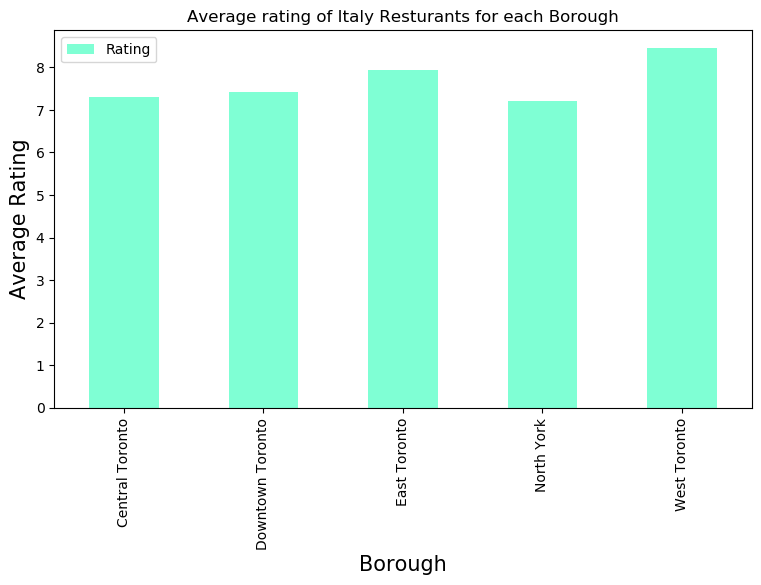

In [59]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italy Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Italy_rest_stats_Toronto.groupby('Borough').mean()['Rating'].plot(kind='bar', color="aquamarine")
#legend
plt.legend()
#displays the plot
plt.show()

I will consider all the neighborhoods with **average rating** greater or equal **8.0** to visualize on map

In [34]:
Toronto_neighborhood_stats=Toronto_neighborhood_stats[Toronto_neighborhood_stats["Average Rating"] >=8.0]

In [35]:
Toronto_neighborhood_stats

,Neighborhood,Average Rating
1,"Brockton, Parkdale Village, Exhibition Place",8.2
3,Christie,8.3
6,Don Mills,8.2
11,"Little Portugal, Trinity",8.7
14,St. James Town,8.1
15,"St. James Town, Cabbagetown",8.6
18,"The Danforth West, Riverdale",8.5


In [36]:
Toronto_neighborhood_stats=pd.merge(Toronto_neighborhood_stats,df_toronto, on='Neighborhood')

In [37]:
Toronto_neighborhood_stats=Toronto_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [38]:
Toronto_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,8.2
1,Downtown Toronto,Christie,43.669542,-79.422564,8.3
2,North York,Don Mills,43.745906,-79.352188,8.2
3,North York,Don Mills,43.725900,-79.340923,8.2
4,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.7
5,Downtown Toronto,St. James Town,43.651494,-79.375418,8.1
6,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.6
7,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,8.5


Next, I will show the data on the **map**.

In [39]:
# create map and display it
Toronto_map = folium.Map(location=geo_location('Toronto.CA'), zoom_start=12)

In [40]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in Toronto_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [41]:
Toronto_neighborhood_stats['Label']=Toronto_neighborhood_stats['Neighborhood']+', '+Toronto_neighborhood_stats['Borough']+'('+Toronto_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(Toronto_map)        
# add incidents to map
Toronto_map.add_child(incidents)

### Results


Based on the above analysis, we can know the followings：

1. there are **10** boroughs and **103** neighborhoods in Toronto.
2. the North York borough has **24** neighborhoods，the second largest borough is Downtown Toronto，it has 19 neighborhoods.
3. there are **38** Italian resturants in Toronto,**Downtown toronto** has the **largest** number of Italian restaurants. There are 24 Italian restaurants in this borough，only 14 Italian resturants at the other boroughs of Toronto.
4. Central Bay Street, the neighborhood with the most Italian restaurants, has a total of five restaurants, Commerce Court, Victoria Hotel neighborhood and Garden Districtand Ryerson neighbourhood, have 4 and 3 Italian restaurants, respectively.
5. the Little Portugal, Trinity neighbourhood of West Tronto borough has the **highest average rating** Italian restaurants，the average rating is **8.7**. followed by St. James Town, Cabbagetown neighborhood，Downtown Toronto borough and The Danforth West, Riverdale，East Toronto borough， the average rating are 8.6 and 8.5 respetively.

### Discussion

I will definately recommend **downtown's** Italian restaurants for travellers. Firstly, downtown Toronto is the borough 
with **the most Italian restaurants**. secondly it has **the second highest rated Italian restaurant**, people can 
have more choices in downtown. Then,I would recommend Ufficio Italian resturant which located in the Little Portugal, 
Trinity neighbourhood, because Ufficio is the **highest rating** Italian restaurant in Toronto.

### Conclusion

In this project,using the data science knowledge I  learned, I conducted an exploration of Italian restaurants in 
Toronto, Canada. Combined various factors such as geographic location and ratings, I successfully recommended Italian restaurants for tourists who like Italian restaurants.Further more,This project can not only provide assistance to those tourists, but can also be applied to other fields, such as: finding the best schools and parks in Toronto, etc., to provide assistance to other stakeholders. However, this project has its limitation. For example: The ratings of restaurants are very subjective, and people do not necessarily like restaurants with high ratings.


The saved image can be downloaded at [here](https://github.com/Bighouse123/Peer-graded-Assignment-Capstone-Project---The-Battle-of-Neighborhoods/blob/master/map.pdf)


